# Word2Vec e Game of Thrones 
Neste notebook, faremos uma análise dos roteiros da série Game of Thrones utilizando Word2Vec. Este dataset pode ser encontrado [aqui](https://www.kaggle.com/anderfj/game-of-thrones-series-scripts-breakdowns) 

## Importando bibliotecas

In [20]:
import pandas as pd
import re 
from time import time
from collections import defaultdict 
import spacy 
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Pré-processamentos

In [7]:
#Carregando o dataset 
df = pd.read_csv('got_scripts_breakdown.csv', sep = ';')
df.drop('Column1', axis=1, inplace=True) 

In [8]:
#Leitura das primeiras linhas do dataset
df.head()

,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [9]:
df.shape

(22510, 7)

#### Criando funções para limpar o texto

In [13]:
nlp = spacy.load('en_core_web_sm')

def limpar_texto(doc):
    """
    Lematiza e retira stopwords.
    O documento precisa ser um objeto spacy
    """
    
    texto = [token.lemma_ for token in doc if not token.is_stop]
    
    if len(texto)>2:
        return " ".join(texto)

In [30]:
#retirando caracteres que não são letras e passando todos eles para sua forma minúscula.
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Sentence']) 

Para aplicar os pré-processamentos, estaremos utilizando a pipeline da biblioteca spaCy. Você pode ler mais sobre isso [aqui](https://spacy.io/api/language#pipe) 

In [31]:
t = time()

#Aplicando as funções 
txt = [limpar_texto(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Tempo para limpar tudo: {} mins'.format(round((time() - t) / 60, 2))) 

Tempo para limpar tudo: 0.72 mins


In [36]:
df_limpo = pd.DataFrame({'texto_limpo': txt})
df_limpo = df_limpo.dropna()

In [38]:
df_limpo.head()

,texto_limpo
0,d expect savage lot steal goat lot know rip piece
1,ve see wildling thing like ve see thing like life
6,order track wildling track win t trouble
7,don t think will ask die horse
9,s good thing child want run away south run awa...


In [39]:
print(df.shape)
print(df_limpo.shape)

(22510, 7)
(13761, 1)


No processo de limpar o nosso texto, retiramos muitas linhas do nosso dataset original que eram compostas apenas por stopwords. Por isso, geramos um novo dataframe apenas com o texto limpo.

## Bigramas
Vamos utilizar o pacote [Gensim Phrases](https://radimrehurek.com/gensim/models/phrases.html) para automaticamente detectar bigramas. Com isso, conseguimos captar expressões como "jon_snow" e "tyrion_lannister". 

In [40]:
from gensim.models.phrases import Phrases, Phraser

Como o `Phrases()` recebe como input uma lista de lista de palavras, vamos fazer esse passo primeiro: 

In [47]:
sent = [row.split() for row in df_limpo['texto_limpo']]

Criando bigramas relevantes a partir da lista de frases:

In [48]:
phrases = Phrases(frases, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

INFO - 16:28:50: collecting all words and their counts
INFO - 16:28:50: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:28:50: PROGRESS: at sentence #10000, processed 77822 words and 54321 word types
INFO - 16:28:50: collected 72644 word types from a corpus of 110250 words (unigram + bigrams) and 13761 sentences
INFO - 16:28:50: using 72644 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 16:28:50: source_vocab length 72644
INFO - 16:28:51: Phraser built with 30 phrasegrams


In [50]:
print(bigram["you know nothing jon snow".split()])

['you', 'know', 'nothing', 'jon_snow']


Como podemos observar, o nome "Jon Snow" foi reconhecido como um bigrama (indicado pelo `_`)

In [49]:
sentences = bigram[sent]

## Word2Vec

In [52]:
import multiprocessing

from gensim.models import Word2Vec

### Os parâmetros
Há uma lista bem extensa com os parâmetros que podemos usar no [word2vec](https://radimrehurek.com/gensim/models/word2vec.html). Aqui, vamos apenas ajustar alguns, e, para os demais, usaremos a configuração padrão.

- `size`: representa aqui a dimensão do espaço vetorial. Como o nosso dataset é relativamente pequeno, vamos usar **80**
- `min_count`: contagem mínima que uma palavra precisa aparecer para ser treinada. Como já tínhamos colocado isso no pré-processamento, aqui vamos usar **2** também.
- `window`: distância entre a palavra atual e a que queremos prever - **2**

In [54]:
w2v_model = Word2Vec(min_count=2, size=80, window=2)

### Construindo a tabela com o vocabulário
Word2Vec requer a construção de uma tabela com o vocabulário (simplesmente seleciona todas as palavras e filtra as que são únicas. Além de fazer algumas contagens com elas)

In [55]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000) 

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:49:42: collecting all words and their counts
INFO - 16:49:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:49:43: PROGRESS: at sentence #10000, processed 76471 words, keeping 5688 word types
INFO - 16:49:43: collected 6675 word types from a corpus of 108063 raw words and 13761 sentences
INFO - 16:49:43: Loading a fresh vocabulary
INFO - 16:49:43: effective_min_count=2 retains 4109 unique words (61% of original 6675, drops 2566)
INFO - 16:49:43: effective_min_count=2 leaves 105497 word corpus (97% of original 108063, drops 2566)
INFO - 16:49:43: deleting the raw counts dictionary of 6675 items
INFO - 16:49:43: sample=0.001 downsamples 62 most-common words
INFO - 16:49:43: downsampling leaves estimated 92177 word corpus (87.4% of prior 105497)
INFO - 16:49:43: estimated required memory for 4109 words and 80 dimensions: 4684260 bytes
INFO - 16:49:43: resetting layer weights


Time to build vocab: 0.04 mins


### Treinando o modelo 


In [56]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:56:52: training model with 3 workers on 4109 vocabulary and 80 features, using sg=0 hs=0 sample=0.001 negative=5 window=2
INFO - 16:56:52: worker thread finished; awaiting finish of 2 more threads
INFO - 16:56:52: worker thread finished; awaiting finish of 1 more threads
INFO - 16:56:52: worker thread finished; awaiting finish of 0 more threads
INFO - 16:56:52: EPOCH - 1 : training on 108063 raw words (92190 effective words) took 0.8s, 114484 effective words/s
INFO - 16:56:53: worker thread finished; awaiting finish of 2 more threads
INFO - 16:56:53: worker thread finished; awaiting finish of 1 more threads
INFO - 16:56:53: worker thread finished; awaiting finish of 0 more threads
INFO - 16:56:53: EPOCH - 2 : training on 108063 raw words (92100 effective words) took 0.6s, 166088 effective words/s
INFO - 16:56:54: worker thread finished; awaiting finish of 2 more threads
INFO - 16:56:54: worker thread finished; awaiting finish of 1 more threads
INFO - 16:56:54: worker thread f

Time to train the model: 0.22 mins


# Explorando o modelo

### `most_similar`

Vamos explorar quais são as palavras mais similares de acordo com alguns elementos da série:

In [57]:
w2v_model.wv.most_similar(positive=["winterfell"])

INFO - 16:58:11: precomputing L2-norms of word weight vectors


[('ramsay', 0.9003156423568726),
 ('snow', 0.8435481786727905),
 ('yield', 0.8368798494338989),
 ('bolton', 0.8281612396240234),
 ('warden', 0.8126554489135742),
 ('ironborn', 0.8078362345695496),
 ('survive', 0.8010543584823608),
 ('dreadfort', 0.8006422519683838),
 ('rickon', 0.7941533923149109),
 ('robb', 0.7893653512001038)]

In [91]:
w2v_model.most_similar('daenerys')

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('stormborn', 0.9299558401107788),
 ('targaryen', 0.9003194570541382),
 ('aegon', 0.8375482559204102),
 ('rhaegar', 0.8020374774932861),
 ('rhaenyra', 0.7979841232299805),
 ('aerys', 0.7943542003631592),
 ('unburnt', 0.7895056009292603),
 ('seven_kingdom', 0.7783940434455872),
 ('queen', 0.7700557112693787),
 ('unhurt', 0.7691372036933899)]

Parece que a longa lista de nomes da Daenerys foi bem captada pelo nosso modelo rs.

Vamos ver quem é o candidato mais discutido quando o assunto é o Trono de Ferro segundo o nosso modelo:

In [60]:
w2v_model.wv.most_similar(positive=["iron_throne"])

[('throne', 0.8914167284965515),
 ('stead', 0.8658596873283386),
 ('proclaim', 0.8646796941757202),
 ('stannis_baratheon', 0.862809956073761),
 ('troublesome', 0.854813814163208),
 ('preside', 0.854607880115509),
 ('prosperity', 0.8501068353652954),
 ('chair', 0.8476023077964783),
 ('view', 0.8456528186798096),
 ('soundly', 0.8442986011505127)]

Dentre outras palavras, parece que o personagem principal inserido nesse contexto é o Stannis Baratheon.

Além disso, também podemos usar essa função para fazer analogias. Qual será que é a palavra que está para "king", assim como "queen" está para "cersei"? 

In [81]:
def analogy(x1, x2, y1):
    result = w2v_model.wv.most_similar(positive = [y1, x2], negative=[x1])
    return result [0][0]

In [82]:
analogy('queen', 'cersei', 'king')

'baratheon'

### `similarity`

Agora, vamos ver quão similares são duas palavras diferentes

In [68]:
w2v_model.wv.similarity('jon', 'king')

0.41593677

In [70]:
w2v_model.wv.similarity('joffrey', 'king')

0.6335297

### `doesnt_match`
Esta função pede para que o nosso modelo encontre o a palavra que não pertence à lista. Aqui, vamos tentar utilizá-la para reconhecer o membro que não pertence àquela família:

In [78]:
w2v_model.wv.doesnt_match(['jon', 'arya', 'joffrey', 'sansa'])

'joffrey'

In [77]:
w2v_model.wv.doesnt_match(['cersei', 'jaime', 'daenerys', 'tyrion'])

'daenerys'

# Visualizações 

In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

* A intenção do notebook é a de explicar como aplicar o word2vec e não como o t-SNE funciona. Se você quiser saber mais sobre isso, você pode começar por [aqui](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [95]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 80), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

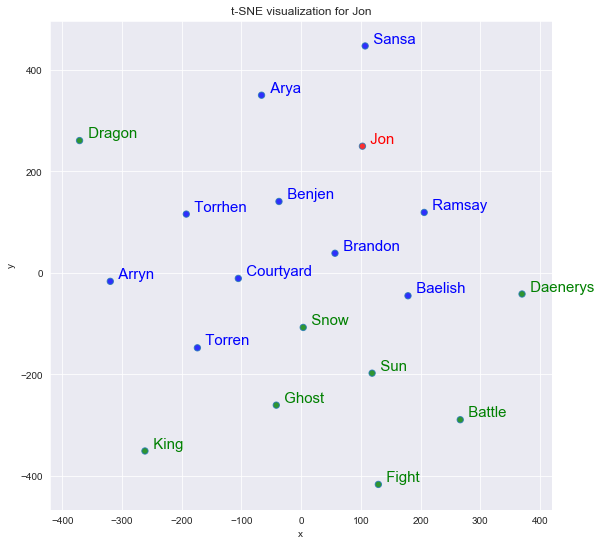

In [96]:
tsnescatterplot(w2v_model, 'jon', ['fight', 'battle', 'sun', 'snow', 'ghost', 'king', 'dragon', 'daenerys']) 

### 10 palavras mais similares VS 10 palavras menos similares

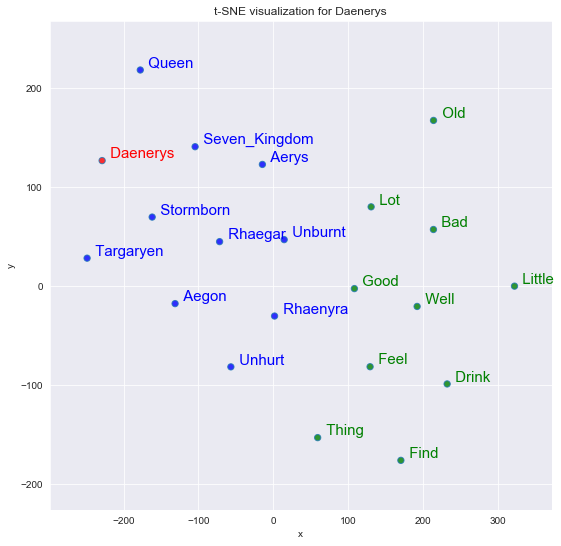

In [97]:
tsnescatterplot(w2v_model, 'daenerys', [i[0] for i in w2v_model.wv.most_similar(negative=["daenerys"])])